# Estimating the reliability of relations extracted by multiple biomedical reading systems with minimal training data

## Abstract

Abstract

## Introduction

Text mining is an increasingly effective tool for extracting structured information from the scientific literature for use in search, data analysis, and modeling (REFs). In the biomedical sciences, both commercial and non-commercial tools have been developed to extract many types of information, including protein-protein interactions (REFs), gene-disease relationships (REFs), and information on gene regulation and function (REFs). With growing interest in rapidly compiling systematic knowledge networks to accelerate discovery, especially in the context of emerging health crises such as COVID-19, interest in and applications of these natural language processing (NLP)  systems is likely to increase (REFs).

As the number and diversity of biomedical NLP systems has increased, it has become increasingly desirable to combine the results from more than one system to boost both the precision and recall of the information extracted. One of the key technical challenges in combining information is the need to estimate the reliability of extractions derived from multiple systems. Combining predictions from multiple classifiers is a well-established way of boosting performance in machine learning applications (REFs). Typically this is achieved by tuning the relative contributions of each classifier using a gold-standard dataset. However, in domains where training data is scarce, as is the case for many biomedical NLP tasks, systems may be based on deterministic rules or heuristics rather than supervised learning, making estimates of reliability difficult even for a single reading system. Even when combining systems based on supervised learning, the data used for the original training and validation may be sufficiently different from the target domain as to make assessments of recall and precision unreliable. This can occur when processing full-text articles after training only on abstracts, or transitioning to a very broad set of documents (e.g. all of PubMed) after training on only highly relevant documents.

In this paper we describe a straightforward approach to estimating joint extraction precision that only requires estimates of the precision of each component reader by assuming that reader errors are independent. These precision values can be based on limited manual curation or even *a priori* estimates. To demonstrate the approach, we obtained a corpus of relations by processing 570,000 scientific abstracts and full-texts with five different reading systems, and manually curated ~1,000 relations supported by ~5,000 underlying sentences for correctness. Using this dataset, we show that even though reader errors are *in fact* correlated, assuming error independence yields relation "belief scores" that, though not representing calibrated probabilities, nevertheless serve as a metric that can be used to adjust the false discovery rate in downstream applications. The receiver-operator characteristics of this approach are comparable to logistic regression and other classification methods, while requiring far less data. In real-world applications where reader overlap is minimal, belief scores are nearly as effective as exact knowledge of the joint probability distribution in separating correct from incorrect extractions.

## Results

### Article corpus, extracted relations, and curated dataset

For this study we defined a corpus of ~580,000 scientific articles enriched for information on protein interactions by searching the Entrez gene database for articles manually curated as relevant to one or more human genes (REF Entrez?). For these articles we obtained <span class="mark">XXX</span> abstracts and <span class="mark">YYY</span> full texts; abstracts were obtained from MEDLINE, full texts were obtained from either 1) the PubMed Central open access subset, 2) the PubMed author's manuscript collection, or 3) the Elsevier text and data mining API.

From these articles we combined extractions from five reading systems: REACH (REF), Sparser (REF), Medscan (REF), RLIMS-P (REF), and TRIPS (REF) and used the INDRA assembly system to normalize the resulting extractions into a consistent format (INDRA Ref). 81% of the assembled relations were obtained from only a single reading system, with the remaining 19% from two or more (<span class="mark">Tables 1 and 2 and Figure 1</span>).

In [2]:
# Imports.
import pickle
import itertools
from collections import Counter
from tqdm import tqdm
import numpy as np
import pandas as pd
from venn import venn
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve
from indra.tools import assemble_corpus as ac

%matplotlib notebook

In [7]:
### Globals ###
# curation_data_file
# reader_list
# reader_abbrevs
# reader_stmts
# kge_df
# bin_df
# reader_counts
# reader_freqs
# curation_freqs, curation_dfs
# stmt_freq_df
# cur_freq_df
# rcount_dict
# outliers
# outlier_filt
# bin_reader_counts
# resampled_df

In [4]:
# Load pickle of assembled statements.
all_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')

INFO: [2020-10-02 09:55:23] indra.tools.assemble_corpus - Loading ../data/bioexp_asmb_preassembled.pkl...
INFO: [2020-10-02 09:56:21] indra.tools.assemble_corpus - Loaded 895580 statements


In [5]:
# Filter out statements with None agents and those with only DB support.
# The list of readers: 
reader_list = ['reach', 'sparser', 'medscan', 'rlimsp', 'trips']
reader_abbrevs = {'reach': 'R', 'sparser': 'S', 'medscan': 'M',
                  'rlimsp': 'P', 'trips': 'T'}
reader_stmts = []
for stmt in tqdm(all_stmts):
    if None in stmt.agent_list():
        continue
    if not set([ev.source_api for ev in stmt.evidence]).intersection(set(reader_list)):
        continue
    reader_stmts.append(stmt)
    

100%|██████████| 895580/895580 [00:03<00:00, 251646.36it/s]


In [8]:
# Load and preprocess the curation dataset.

curation_data_file = 'kge_dataset.pkl'

def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'stmt_type', 'agB_name')}
    df = df.astype(dtype_dict)
    return df

def binarize_count_data(df):
    # First convert to true/false
    dtype_dict = {col: 'bool' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name', 'stmt_type', 'agB_name')}
    bin_df = df.astype(dtype_dict)
    # Then convert true/false into 1/0
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name', 'stmt_type', 'agB_name')}
    bin_df = bin_df.astype(dtype_dict)
    return bin_df

kge_df = load_curation_data(curation_data_file)
bin_df = binarize_count_data(kge_df)

In [9]:
# Table 1: Distribution of reader frequencies in corpus and curation data.
# (excluding database only statements)

def reader_set_to_tuple(rset, r_list, r_abbrevs):
    """Converts a frozen set of sources e.g. {reach, sparser} into a tuple 
       of the form (R, S, _, _, _) for use in displaying results."""
    rtup = []
    # Follow the order of readers in reader_list
    for r in r_list:
        if r in rset:
            rtup.append(r_abbrevs[r])
        else:
            rtup.append('_')
    return tuple(rtup)

def get_reader_freq_from_stmts(stmts, source_list, source_abbrevs):
    """Return dictionary showing frequency of reader combinations."""
    all_ev_cts = []
    # Get unique reader evidence sources for each statement
    for stmt in tqdm(stmts):
        sources = frozenset([ev.source_api for ev in stmt.evidence
                       if ev.source_api in source_list])
        if sources:
            all_ev_cts.append(sources)
    # Build up a dictionary mapping the reader combinations (as frozensets) to their
    # frequency in the set of statements
    all_ev_ctr = Counter(all_ev_cts)
    #all_ev_ctr_list = sorted([(k, (v / len(all_ev_cts)))
    #                          for k, v in all_ev_ctr.items()], key=lambda x: x[1], reverse=True)
    all_ev_ctr_dict = {reader_set_to_tuple(k, source_list, source_abbrevs):
                       (v / len(all_ev_cts)) for k, v in all_ev_ctr.items()}
    return all_ev_ctr_dict

def get_reader_counts_from_stmts(stmts):
    data = []
    for stmt in tqdm(stmts):
        ev_dict = dict(Counter([ev.source_api for ev in stmt.evidence]))
        ev_dict['stmt_hash'] = stmt.get_hash()
        ev_dict['stmt_type'] = stmt.__class__.__name__
        ev_dict['agA_name'] = stmt.agent_list()[0].name
        if len(stmt.agent_list()) == 2:
            ev_dict['agB_name'] = stmt.agent_list()[1].name
        else:
            continue
        data.append(ev_dict)
    df = pd.DataFrame(data).fillna(0)
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name', 'stmt_type', 'agB_name')}
    return df.astype(dtype_dict)

def get_reader_freq_from_curation(df, col_list, r_abbrevs=None):
    """Build up dictionary of the proportions of each evidence combination in the
       curation dataset. Also return a mapping between the unique evidence combo
       and a dataframe with the curated statements for that combination."""
    if r_abbrevs is None:
        r_abbrevs = {c: c for c in col_list}
    df_ev_dict = {}
    total_rows = df.shape[0]
    df_subgroup_dict = {}
    for gb_key, gb_df in df.groupby(by=col_list):
        freq = (gb_df.shape[0] / total_rows) # Proportion of rows from this group
        label_set = frozenset([col for ix, col in enumerate(col_list)
                               if gb_key[ix] == 1])
        label_tup = reader_set_to_tuple(label_set, col_list, r_abbrevs)
        df_ev_dict[label_tup] = freq
        df_subgroup_dict[label_tup] = gb_df
    return (df_ev_dict, df_subgroup_dict)

def make_df(d, index_name, colname):
    """Build dataframe from a dictionary with dict keys as the index."""
    index, raw_cols = zip(*d.items())
    cols = tuple([c for c in raw_cols])
    index_obj = pd.Index(index, name=index_name, tupleize_cols=False)
    return pd.DataFrame(cols, columns=[colname], index=index_obj)

reader_counts = get_reader_counts_from_stmts(reader_stmts)
reader_freqs = get_reader_freq_from_stmts(reader_stmts, reader_list, reader_abbrevs)
curation_freqs, curation_dfs = get_reader_freq_from_curation(bin_df, reader_list, reader_abbrevs)
stmt_freq_df = make_df(reader_freqs, 'Readers', 'Corpus Freq.')
cur_freq_df = make_df(curation_freqs, 'Readers', 'Curation Freq.')
stmt_freq_df.join(cur_freq_df).sort_values('Corpus Freq.', ascending=False).fillna(0)

100%|██████████| 705022/705022 [00:01<00:00, 400219.61it/s]


,Corpus Freq.,Curation Freq.
Readers,,
"(R, _, _, _, _)",0.449950,0.180171
"(_, _, M, _, _)",0.201791,0.000000
"(_, S, _, _, _)",0.153938,0.034115
"(R, _, M, _, _)",0.078537,0.069296
"(R, S, _, _, _)",0.049878,0.067164
"(R, S, M, _, _)",0.028466,0.060768
"(_, S, M, _, _)",0.010037,0.005330
"(R, S, M, _, T)",0.005133,0.154584
"(_, _, _, _, T)",0.004401,0.065032


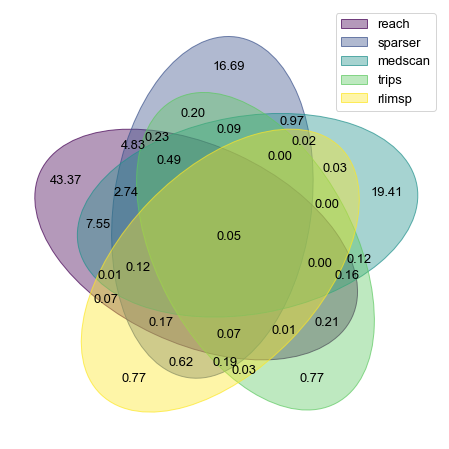

In [10]:
# Figure 1: Venn diagram of reader frequencies in corpus.
def source_venn(stmts, source_list):
    reader_uuids = {}
    for stmt in stmts:
        stmt_sources = frozenset([ev.source_api for ev in stmt.evidence
                             if ev.source_api in source_list])
        # Skip statements with no sources in the given list
        if not stmt_sources:
            continue
        for source in stmt_sources:
            if source not in reader_uuids:
                reader_uuids[source] = set()
            reader_uuids[source].add(stmt.uuid)
    return reader_uuids

venn(source_venn(all_stmts, reader_list), fmt='{percentage:.2f}')

In [11]:
# Table 2: Frequencies of relations in corpus by total number of sources.
def marginal_reader_freqs(freqs):
    rcount_dict = {}
    for rtup, freq in freqs.items():
        # Count the number of readers in the freq key tuple
        # Make a set, then turn into a string, then replace'_' with nothing
        rstr = ''.join(set(rtup)).replace('_', '')
        rcount = len(rstr)
        if rcount not in rcount_dict:
            rcount_dict[rcount] = 0
        rcount_dict[rcount] += freq
    return rcount_dict

rcount_dict = marginal_reader_freqs(reader_freqs)
make_df(rcount_dict, 'Num. readers', 'Freq.')

,Freq.
Num. readers,
1,0.813014
2,0.144215
3,0.035539
4,0.006722
5,0.000509


To evaluate different approaches to estimating the reliability we curated a corpus of relations drawn from each reader. For each of the five reading systems we sampled relations supported by between one and ten evidence sentences processed by that reader. For each relation, we manually reviewed each evidence sentence to determine whether it supported the relation extracted by the reader. A relation was determined to be "correct" if it was supported by at least one evidence sentence from any reader. The resulting dataset is comprised of ~1000 curated statements with ~5000 manually curated evidences. Because sampling was stratified both by reader and by the number of supporting sentences, the curated dataset has a substantially different reader distribution than the underlying corpus: for example, statements from TRIPS alone (which was only used to process a subset of abstracts: <span class="mark">see Methods</span>) accounted for only 0.8% of statements in the full corpus but 6.5% of statements in the curated dataset (Table 1).

### Correlations among readers at the mention and relation levels

Readers showed substantial correlation in the number of individual mentions they identified for a relation, with $\rho(Reach, Sparser)$ and $\rho(Reach, Medscan)$ > 0.6 (Table 3). However, the strong correlations among Reach, Sparser, and Medscan were driven by subset of relations with very high numbers of mentions, as shown by a scatter plot of mention counts for Reach and Sparser (Figure 2). Removing just the two outlying points with the largest numbers of mentions ("TNF activates NFkappaB" and "TP53 binds MDM2") reduced $\rho(Reach, Sparser)$ to 0.55 (Table 4). The likelihood of reader overlap is largely a function of the number of times a relation appears in the corpus, which can be seen using reader mentions as a proxy for underlying frequency (Figure 3).

In [12]:
# Table 3. Correlations among readers in mention counts.
reader_counts[reader_list].corr()

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,0.610648,0.632608,0.071888,0.373680
sparser,0.610648,1.000000,0.453898,0.113957,0.419828
medscan,0.632608,0.453898,1.000000,0.033821,0.337839
rlimsp,0.071888,0.113957,0.033821,1.000000,0.095912
trips,0.373680,0.419828,0.337839,0.095912,1.000000


INFO: [2020-10-02 09:58:06] numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: [2020-10-02 09:58:06] numexpr.utils - NumExpr defaulting to 8 threads.


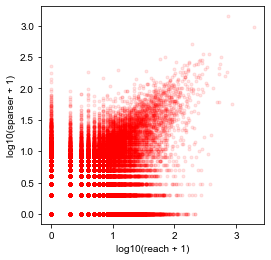

In [13]:
# Figure 2: Scatter plot of mention counts from Reach and Sparser.
def rand_jitter(arr, jitter=0.01):
    stdev = jitter * (max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def reader_corr_plot(count_df, reader1, reader2, jitter=0.01, logscale=True):
    plt.figure(figsize=(4, 4))
    #kge_cp  = count_df[(kge_df[reader1] > 0) | (kge_df[reader2] > 0)]
    if logscale:
        r1_counts = np.log10(count_df[reader1] + 1)
        r2_counts = np.log10(count_df[reader2] + 1)
        xlabel = f'log10({reader1} + 1)'
        ylabel = f'log10({reader2} + 1)'        
    else:
        r1_counts = count_df[reader1].values
        r2_counts = count_df[reader2].values
        xlabel = reader1
        ylabel = reader2    
    plt.plot(rand_jitter(r1_counts, jitter),
             rand_jitter(r2_counts, jitter), linestyle='', marker='.',
             color='red', alpha=0.1, label='Correct')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.legend(loc='upper left', frameon=False)
    #plt.figtext(0.5, 0.01, "A figure legend.", wrap=True, horizontalalignment='center', fontsize=14)
    plt.show()

reader_corr_plot(reader_counts, 'reach', 'sparser', jitter=0, logscale=True)

In [14]:
# Table 4: Mention correlations after filtering out two outlying points with many mentions.
outliers = reader_counts[reader_counts['sparser'] > 800]
outlier_filt = reader_counts.drop(outliers.index)
outlier_filt[reader_list].corr()

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,0.550781,0.548421,0.080636,0.325913
sparser,0.550781,1.000000,0.364867,0.132939,0.332754
medscan,0.548421,0.364867,1.000000,0.037220,0.290822
rlimsp,0.080636,0.132939,0.037220,1.000000,0.100157
trips,0.325913,0.332754,0.290822,0.100157,1.000000


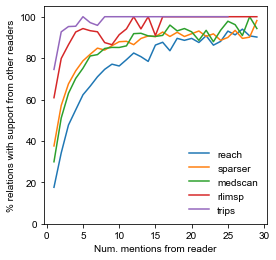

In [15]:
# Figure 3: Reader overlap as a function of mentions.
def plot_joint_vs_reader_count(count_df, reader_list):
    plt.figure(figsize=(4, 4))
    for reader in reader_list:
        count_df = reader_counts
        other_readers = [r for r in reader_list if r != reader]
        x_vals = []
        y_vals = []
        for reader_count in range(1, 30):
            recs_for_count = count_df[count_df[reader] == reader_count]
            if recs_for_count.shape[0] == 0:
                continue
            x_vals.append(reader_count)
            y_vals.append(100*recs_for_count[other_readers].any(1).mean())
        plt.plot(x_vals, y_vals, label=reader)
    plt.xlabel(f'Num. mentions from reader')
    plt.ylabel(f'% relations with support from other readers')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(0, 105)
    plt.show()

plot_joint_vs_reader_count(reader_counts, reader_list)

When mention counts were ignored and only the binary presence/absence of reader support was considered, correlations were small or moderately negative, because the readers contribute separately to the overall corpus but with little overlap on average (Table 5; also Table 1, Figure 1). This is most easily understood for the simplest case of a corpus with output from only two readers, where all correlations would be less than or equal to zero. If the readers were fully complementary (one reader yielding 1 for the other's 0 and vice versa) the correlation would clearly be -1; on the other hand, if the readers were in total agreement (produced identical output), the dataset would contain no zeros at all (because the corpus contains only relations with support from at least one reader) and hence the variances, covariances and correlations would all be zero.

In our dataset with five readers, the readers which produced the majority of the relations (Reach, Sparser, and Medscan) had only negative correlations with each other (Table 5), because the majority of their output was supported by one or two mentions (Table 6), and lacked overlap with other readers (Table 7). RLIMS-P and TRIPS exhibited positive correlations with other readers at the relation level, due to the fact that a large proportion of their overall smaller number of extractions overlapped with extractions from other readers (Table 7).

In [16]:
# Table 5: Correlations among readers at the relation level
bin_reader_counts = binarize_count_data(reader_counts)
bin_reader_counts[reader_list].corr()

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,-0.241753,-0.474403,-0.020938,-0.015515
sparser,-0.241753,1.000000,-0.128048,0.078555,0.111548
medscan,-0.474403,-0.128048,1.000000,-0.010978,0.047709
rlimsp,-0.020938,0.078555,-0.010978,1.000000,0.069556
trips,-0.015515,0.111548,0.047709,0.069556,1.000000


In [17]:
# Table 6: Proportion of relations from each reader with 1 or >1 mentions.
def one_or_more_mentions(reader_counts, reader_list):
    nz = reader_counts[reader_list].apply(lambda x: x > 0, axis=0).sum()
    one = reader_counts[reader_list].apply(lambda x: x == 1, axis=0).sum()
    multi = reader_counts[reader_list].apply(lambda x: x > 1, axis=0).sum()
    one_ser = one / nz
    multi_ser = multi / nz
    one_ser.name = '=1 mention'
    multi_ser.name = '>1 mentions'
    return pd.concat([one_ser, multi_ser], axis=1)

one_or_more_mentions(reader_counts, reader_list)

,=1 mention,>1 mentions
reach,0.675077,0.324923
sparser,0.618371,0.381629
medscan,0.711481,0.288519
rlimsp,0.636058,0.363942
trips,0.833957,0.166043


In [84]:
# Table 7: Proportion of relations with overlap with other readers
def overlap_or_not(reader_counts, reader_list):
    col_names = ["No overlap", "Overlap"]
    no_ovl_data = []
    ovl_data = []
    for reader in reader_list:
        other_readers = [r for r in reader_list if r != reader]
        r_df = reader_counts[reader_counts[reader] != 0]
        overlap_pct = r_df[other_readers].any(1).mean()
        ovl_data.append(overlap_pct)
        no_ovl_data.append(1 - overlap_pct)
    return pd.DataFrame(zip(no_ovl_data, ovl_data), index=reader_list, columns=col_names)

overlap_or_not(reader_counts, reader_list)

,No overlap,Overlap
reach,0.724879,0.275121
sparser,0.501262,0.498738
medscan,0.610968,0.389032
rlimsp,0.300823,0.699177
trips,0.222587,0.777413


### Relation correctness as a function of reader overlap

We then examined the relationship between reader overlap and reader correctness using our manually curated dataset. At the mention level, statements supported by many mentions were both more likely to overlap with other readers and to be scored as correct (Figure 4). Notably, we found that for Reach, the reader with the most extensive subset of curated relations, the probability of relation correctness went up with the overall number of Reach mentions, but only for high-mention statements that also included support from other readers. For relations with support only from Reach, probability of correctness went up from 1 to 2 mentions, but additional Reach-only mentions were not associated with any further increase in precision (Figure 5).

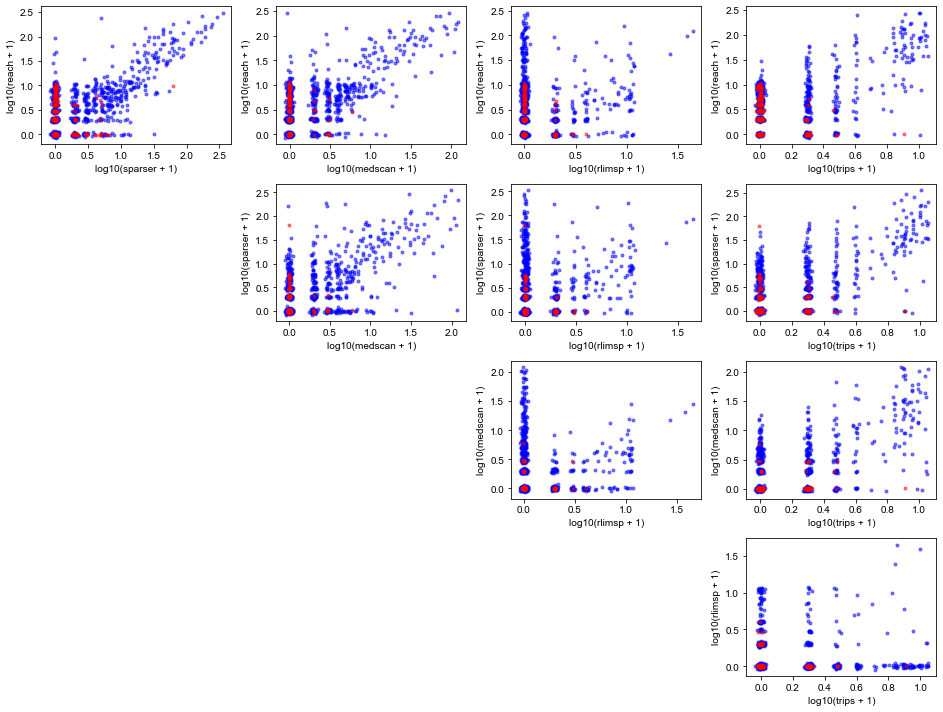

In [91]:
# Figure 4: Statement overlap at mention level and probability of correctness.
def plot_overlap_correctness(count_df, readers):
    r_pairs = list(itertools.product(readers, readers))
    plotted = set()
    plt.figure(figsize=(16, 10))
    n_rows = len(readers) - 1
    n_cols = len(readers)
    for i, (reader1, reader2) in enumerate(r_pairs):
        fs_readers = frozenset((reader1, reader2))
        if reader1 == reader2 or fs_readers in plotted:
            continue
        plotted.add(fs_readers)
        plt.subplot(n_rows, n_cols, i+1)
        incorr = count_df[count_df['correct'] == 0]
        corr = count_df[count_df['correct'] == 1]
        for df, color, label in ((corr, 'blue', 'Correct'),
                                 (incorr, 'red', 'Incorrect')):
            r1_counts = np.log10(df[reader1] + 1)
            r2_counts = np.log10(df[reader2] + 1)
            plt.plot(rand_jitter(r2_counts),
                     rand_jitter(r1_counts), linestyle='', marker='.',
                     color=color, alpha=0.5, label=label)
        plt.xlabel(f'log10({reader2} + 1)')
        plt.ylabel(f'log10({reader1} + 1)')
    #plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plot_overlap_correctness(kge_df, reader_list)

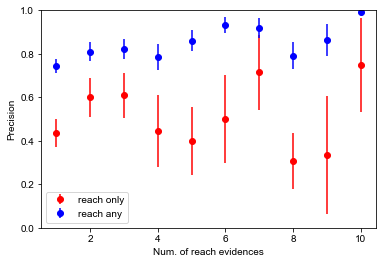

In [96]:
# Figure 5: Correctness vs. Reach mentions with and without reader overlap
def reader_corr_vs_overlap(ct_df, reader):
    source_cols = ['medscan', 'reach', 'sparser', 'rlimsp', 'trips', 'hprd', 'isi',
                   'biopax', 'bel', 'signor', 'trrust']
    source_cols.pop(source_cols.index(reader))
    # Reader only dataframe
    ro_df = ct_df[~ct_df[source_cols].any(axis=1)]
    x = list(range(1, 11))
    r_only = []
    r_all = []
    r_only_cts = []
    r_all_cts = []

    def stderrp(p, n):
        pa = np.array(p)
        na = np.array(n)
        return(np.sqrt((pa*(1-pa))/na))

    for i in x:
        lb = i
        if i < 10:
            ub = i+1
        else:
            ub = 10000

        r_only_rows = ro_df[(ro_df[reader] >= lb) & (ro_df[reader] < ub)]
        r_only.append(r_only_rows['correct'].mean())
        r_only_cts.append(len(r_only_rows['correct']))
        r_all_rows = kge_df[(kge_df[reader] >= lb) & (kge_df[reader] < ub)]
        r_all.append(r_all_rows['correct'].mean())
        r_all_cts.append(len(r_all_rows['correct']))

    plt.figure()
    plt.errorbar(x, r_only, linestyle='', yerr=stderrp(r_only, r_only_cts), marker='o', color='r', label=f'{reader} only')
    plt.errorbar(x, r_all, linestyle='', yerr=stderrp(r_all, r_all_cts), marker='o', color='b', label=f'{reader} any')
    plt.legend(loc='lower left')
    plt.ylabel('Precision')
    plt.xlabel(f'Num. of {reader} evidences')
    plt.ylim([0, 1])
reader_corr_vs_overlap(kge_df, 'reach')

### Resampling correctness dataset to match reader distribution in corpus


In [110]:
# Resample the curation data to match reader frequency distribution
def resample_curation_data(all_ev_ctr_dict, df_ev_dict, df_subgroup_dict,
                           tgt_size=30000, sampling='weighted'):
    """Generate a new dataset by resampling from curation dataset.
    
    Parameters
    ----------
    sampling : str
        Type of sampling, 'uniform' or 'weighted'. If uniform, all reader combinations
        are equally represented. If 'weighted' (default), follows frequency distribution from
        all_ev_ctr_dict. 
    """
    # Uniform sampling
    if sampling == 'uniform':
        tgt_frac = 1 / len(df_ev_dict)
        all_ev_adj_dict = {}
        for ev_combo in df_ev_dict:
            all_ev_adj_dict[ev_combo] = tgt_frac
    # Resample proportions from the original corpus to allow only those combos found in the
    # curation dataset
    else:
        adjust_total = 0
        for k, v in all_ev_ctr_dict.items():
            if k in df_ev_dict:
                adjust_total += v
            else:
                print(f"{k} not yet curated. Freq in corpus {v}.")
        all_ev_adj_dict = {k: (v/adjust_total) for k, v in all_ev_ctr_dict.items() if k in df_ev_dict}
        # Note that the adjusted dictionary only accounts for 80% of the statement evidence combinations
        # in the original dataset
        print("Adjusted total percentage:", adjust_total)

    # Now, iterate over each combination, determine how many records from the curation dataset
    # we need to sample based on the target proportion and overall dataset sizes.
    # Build up a list of Dataframes, one for each evidence combination, which we then concatenate
    # together at the end.
    tgt_counts = {}
    df_samples = []
    frac_counts = {}
    # Iterate over the reader combos in the curated data
    for ev_combo in df_ev_dict:
        # Get the target resampled count for this combination
        tgt_count = int(all_ev_adj_dict[ev_combo] * tgt_size)
        # If the tgt_count rounds down to 0, round up to 1.
        if tgt_count == 0:
            tgt_count = 1
        # Save the count for this reader combo
        tgt_counts[ev_combo] = tgt_count
        # FIXME TODO
        ev_combo_df = df_subgroup_dict[ev_combo]
        # Sample tgt_count entries with replacement from the subset of 
        # curation data for this reader combo
        df_samples.append(ev_combo_df.sample(tgt_count, replace=True))
    resampled_df = pd.concat(df_samples, ignore_index=True)
    return resampled_df

resampled_df = resample_curation_data(reader_freqs, curation_freqs, curation_dfs, tgt_size=30000)

('_', '_', 'M', '_', '_') not yet curated. Freq in corpus 0.20179086610063232.
('_', '_', 'M', 'P', 'T') not yet curated. Freq in corpus 1.985753636056747e-05.
Adjusted total percentage: 0.798189276363007


### Bahadur Lazarsfeld second order model

The notation/nomenclature in the functions below here is based on page 3 of "Estimation in second order dependency model for multivariate binary data", E.H.S. Ip. Link [here](https://statistics.stanford.edu/sites/g/files/sbiybj6031/f/OLK%20NSF%20302.pdf). 

In [19]:
# Function for calculating conditional probabilities
def prob(v, c=None, df=None):
    """Probability of variables v: vals conditioned on variables c: vals"""
    if df is None:
        raise ValueError("df must be given.")
    if c is None:
        c = []
    if not v:
        raise ValueError("v variables must be specified")
    c_df = df
    for c_var, c_val in c:
        c_df = c_df[c_df[c_var] == c_val]
    # Handle the case where the conditional event does not occur
    if len(c_df) == 0:
        return 0
    vc_df = None
    for v_var, v_val in v:
        if vc_df is None:
            vc_df = c_df[c_df[v_var] == v_val]
        else:
            vc_df = vc_df[vc_df[v_var] == v_val]
    return len(vc_df) / len(c_df)

In [20]:
# Implementations of Exact probability, Belief scores, and BL Expansions as sklearn models.
class BLPredictor(object):
    def __init__(self, df=None, order=2):
        self.df = df
        self.order = order
        
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Get the unique input vectors in x_train
        x_val_combos_in_data = set([tuple(x_train[ix, :]) for ix in range(x_train.shape[0])])
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            # If this combination doesn't actually occur, set to NaN in the cache and skip
            if x_vals not in x_val_combos_in_data:
                self.prob_cache[x_vals] = np.nan
                continue
            x_vect = list(x_vals) + [y_target]
            col_vals = list(zip(range(len(x_vect)), x_vect))
            joint_prob = self.bahadur_laz(col_vals, max_order=self.order)
            denom = prob(col_vals[:-1], df=self.df)
            pred_prob = joint_prob / denom
            if pred_prob > 1:
                pred_prob = 1.0
            elif pred_prob < 0:
                pred_prob = 0.
            self.prob_cache[x_vals] = pred_prob
        
    def predict_proba(self, x_arr, order=2, threshold=0.5):
        if x_arr.shape[1] != self.df.shape[1] - 1:
            raise ValueError("Prediction data is wrong shape.")
        y_probs = np.zeros((x_arr.shape[0], 2))
        for row_ix in range(x_arr.shape[0]):
            x_vals = x_arr[row_ix, :]
            # Get the computed value for this feature vector from the cache
            pred_prob = self.prob_cache[tuple(x_vals)]
            # If we didn't see it in training, we just fall back on p(correct)
            if pred_prob is np.nan: 
                pred_prob = prob([(len(x_vals)-1, self.y_target)], df=self.df)
            y_probs[row_ix, 0] = 1 - pred_prob
            y_probs[row_ix, 1] = pred_prob
        return y_probs
    
    def predict(self, x_arr, order=2, threshold=0.5):
        if x_arr.shape[1] != self.df.shape[1] - 1:
            raise ValueError("Prediction data is wrong shape.")
        y_probs = np.zeros((x_arr.shape[0], 2))
        y_preds = self.predict_proba(x_arr, order, threshold)
        for row_ix, pred_prob in enumerate(y_preds):
            if pred_prob[1] is np.nan:
                pred = np.nan
            else:
                pred = 0 if pred_prob[1] < threshold else 1
            y_preds[row_ix] = pred
        return y_preds

    # alpha(Yi) = E(Yi), i.e., probability Yi = 1, i.e., p in the usual notation for bernoulli variables.
    def alpha(self, col):
        return self.df[col].mean()

    # This function returns the probability  p(Y1 = y1, Y2=y2, Y3=y3...) etc. as the product of
    # the independent probabilities i.e., p(Y1=y1)*p(Y2=y2)*p(Y3=y3)*...
    def p1y(self, col_vals):
        prod = 1
        for col, val in col_vals:
            if val not in (0, 1):
                raise ValueError("Values must be 0 or 1")
            prod *= (self.alpha(col)**val) * (1 - self.alpha(col))**(1 - val)
        return prod

    # W has two senses in the notation used by Ip. If no value is given (val=None),
    # evaluates to (Yi - p)/sqrt(pq) = a standardized version of Yi (offset by the mean and divided by the SD).
    # If given a specific value yi (0 or 1), gives the standardized probability of yi.
    def W(self, col, val=None):
        a = self.alpha(col)
        denom = np.sqrt(a * (1 - a))
        if val is None:
            numer = (self.df[col] - a).values
        else:
            numer = val - a
        return numer / denom

    # Returns E(W1*W2*...*Wi). For the case of two variables Yi and Yj, r_ij = E(Wi*Wj) is
    # equivalent to the correlation between Yi and Yj.
    def r(self, cols):
        return np.mean(np.prod(np.stack([self.W(col) for col in cols]), axis=0))

    # For a set of values associated with variables, i.e., y1, y2, ... yn,
    # returns the product W(y1)*W(y2)*...*W(yn), i.e., the product of the normalized
    # probabilities of each Yi taking a specific value yi.
    def W_prod(self, col_vals):
        return np.prod([self.W(col, val) for col, val in col_vals])

    # Generates a term in the expansion of the given order. For order 2,
    # returns sum_(j<k) {rjk * Wj * Wk}, i.e., based on pairwise correlations.
    def term(self, col_vals, order):
        total = 0
        for col_val_combo in itertools.combinations(col_vals, order):
            r_term = self.r([col for col, val in col_val_combo])
            W_term = self.W_prod(col_val_combo)
            total += r_term * W_term
        return total

    def bahadur_laz(self, col_vals, max_order=2):
        fy = 1
        if max_order < 1 or max_order > len(self.df.columns):
            raise ValueError('max_order must be between 1 and len(col_vals)')
        for order in range(2, max_order+1):
            fy += self.term(col_vals, order)
        return self.p1y(col_vals) * fy    

    
class ProbPredictor(BLPredictor):
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Get the unique input vectors in x_train
        x_val_combos_in_data = set([tuple(x_train[ix, :]) for ix in range(x_train.shape[0])])
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            # If this combination doesn't actually occur, set to NaN in the cache and skip
            if x_vals not in x_val_combos_in_data:
                self.prob_cache[x_vals] = np.nan
                continue
            x_vect = list(x_vals) + [y_target]
            col_vals = list(zip(range(len(x_vect)), x_vect))
            pred_prob = prob(col_vals, col_vals[:-1], df=self.df)
            self.prob_cache[x_vals] = pred_prob
    
    
class BeliefPredictor(BLPredictor):
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Calculate the error probabilities for each reader column
        err_probs = {}
        for col_ix in range(self.df.shape[1]-1):
            err_probs[col_ix] = 1 - self.df[self.df[col_ix] == 1][self.y_ix].mean()
        # Here, we actually iterate over all combinations of input vectors and compute belief
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            total_err_prob = 1
            for col_ix, x_val in enumerate(x_vals):
                # Multiply by the error probabilities for any readers with evidence
                if x_val == 1:
                    total_err_prob *= err_probs[col_ix]
            pred_prob = 1 - total_err_prob
            self.prob_cache[x_vals] = pred_prob

# Train Models

In [ ]:
# Option 1: include stmt_type (encoded) and score
#df = kge_join.drop(columns=['stmt_hash', 'stmt_num', 'agA_name', 'agB_name'])
#le = LabelEncoder()
#le.fit(df.stmt_type)
#df.stmt_type = le.transform(df.stmt_type)

# Option 2: Only include binarized reader info
reader_list = ['rlimsp', 'medscan', 'trips', 'reach', 'sparser']
#readers_to_include = ['reach', 'sparser']
readers_to_include = reader_list
readers_to_drop = [r for r in reader_list if r not in readers_to_include]
db_list = ['hprd', 'isi', 'biopax', 'bel', 'signor', 'trrust']

df_for_pred = resampled_df
#df_for_pred = bin_df_sub
df_for_pred = df_for_pred[df_for_pred[readers_to_include].apply(lambda x: np.any(x), axis=1)]


In [ ]:
df = df_for_pred.drop(columns=['stmt_hash', 'stmt_num', 'agA_name', 'agB_name', 'stmt_type']
                               + db_list + readers_to_drop)
# Get dataset with int-encoded statement type and no class attribute (correct)
x_df = df.drop('correct', axis=1)
x = x_df.values
# Class vector
y = df.correct.values
test_split = 0.2
test_size = int(len(y) * test_split)

In [ ]:
num_folds = 10
models = {
    'Belief': BeliefPredictor(),
    'ExactProb': ProbPredictor(),
    'Logistic Regression': LogisticRegression(),
    'BL2': BLPredictor(order=2),
    'BL6': BLPredictor(order=6),

    #'Random Forest Classifier': RandomForestClassifier(),
}
predictors = {'': x, #'All features': x,
              #'Without KGE': x[:, :-1], # Drop the score column
              #'Only KGE': x[:, -1:]} # Only the score column
             }
clf_results = {}
roc_results = {}
roc_aucs= {}
prec_results = {}
rec_results = {}
pr_aucs = {}
# For each model...
base_fpr = np.linspace(0, 1, 101)
for clf_name, clf in models.items():
    # Try different predictors...
    for pred_name, pred_x in predictors.items():
        # Fold the data multiple times
        # Save the data in a matrix (num_folds, test_size)
        tpr_arr = np.zeros((num_folds, len(base_fpr)))
        prec_arr = np.zeros((num_folds, len(base_fpr)))
        rec_arr = np.zeros((num_folds, len(base_fpr)))
        roc_auc_arr = np.zeros(num_folds)
        pr_auc_arr = np.zeros(num_folds)
        for fold_ix in range(num_folds):
            # Split the data
            x_train, x_test, y_train, y_test = train_test_split(pred_x, y, test_size=test_size)
            print(clf_name, pred_name, x_train.shape)
            # Train the model
            if clf_name == 'ExactProb':
                clf.fit(pred_x, y)
            else:
                clf.fit(x_train, y_train)
            # Save the data
            clf_result = {}
            clf_result['y_preds'] = clf.predict(x_test)
            clf_result['y_probs'] = clf.predict_proba(x_test)
            
            # Compute ROC curve and ROC area for each class
            #roc_results = {}
            fpr, tpr, thresholds = roc_curve(y_test, clf_result['y_probs'][:, 1])
            roc_auc = auc(fpr, tpr)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tpr_arr[fold_ix, :] = tpr
            roc_auc_arr[fold_ix] = roc_auc
            
            precision, recall, thresholds = precision_recall_curve(y_test, clf_result['y_probs'][:, 1])
            pr_auc = metrics.auc(recall, precision)
            pr_auc_arr[fold_ix] = pr_auc
            prec_arr[fold_ix, :] = interp(base_fpr, thresholds, precision[:-1])
            rec_arr[fold_ix, :] = interp(base_fpr, thresholds, recall[:-1])
            #roc_result = {}
            #roc_result['fpr'] = fpr
            #roc_result['tpr'] = tpr
            #roc_result['roc_auc'] = roc_auc
            #roc_results[clf_name] = roc_result
            
        model_key = '%s %s' % (clf_name, pred_name)
        roc_results[model_key] = tpr_arr.mean(axis=0)
        clf_results[model_key] = clf_result
        roc_aucs[model_key] = roc_auc_arr
        prec_results[model_key] = prec_arr.mean(axis=0)
        rec_results[model_key] = rec_arr.mean(axis=0)
        pr_aucs[model_key] = pr_auc_arr

In [ ]:
# Example prediction 
x_df.columns

In [ ]:
# For a single Sparser evidence
ex = np.array([[0, 0, 1, 0, 0]])
#ex = np.array([[0, 0, 1]])

#models['Logistic Regression'].predict_proba(ex)
print("ExactProb", models['ExactProb'].predict_proba(ex))
print("BL2", models['BL2'].predict_proba(ex))
print("Belief", models['Belief'].predict_proba(ex))

#models['Belief'].predict_proba(ex)
#models['Random Forest Classifier'].predict_proba(sparser_ex)

# ROC Curves

In [ ]:
roc_results.keys()

In [ ]:
plt.figure()
lw = 2
colors = ['r', 'g', 'b', 'orange', 'k', 'y']

# Plot ROC curve for Belief Model (REACH)
#plt.plot(bel_fpr, bel_tpr, color=colors[0],
#         lw=lw, label='Orig. Belief (area = %0.2f)' % bel_roc_auc)
for i, (clf_name, roc_result) in enumerate(roc_results.items()):
    #fpr = roc_result['fpr']
    #tpr = roc_result['tpr']
    roc_auc_arr = roc_aucs[clf_name]
    plt.plot(base_fpr, roc_result, color=colors[i],
         lw=lw, label='%s (area = %0.2f +/- %0.2f)' %
                      (clf_name, roc_auc_arr.mean(), roc_auc_arr.std()))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('bel_roc.pdf')
plt.show()


In [ ]:


df = None
for model_name in ('ExactProb', 'BL2', 'BL6', 'Belief',):
    new_df = make_df(models[model_name].prob_cache, model_name)
    if df is None:
        df = new_df
    else:
        df = df.join(new_df)

# Get probabilities from logistic regression model
lr_probs = {}
for ev_tuple in models[model_name].prob_cache.keys():
    prob = models['Logistic Regression'].predict_proba([ev_tuple])[0][1]
    lr_probs[ev_tuple] = prob
lr_df = make_df(lr_probs, 'LogReg')
df = df.join(lr_df)
        
# Combine with info on frequency
col_names = list(x_df.columns)
freq_vals = {}
for ev_tuple in models[model_name].prob_cache.keys():
    ev_key = frozenset([col_names[ix] for ix, val in enumerate(ev_tuple) if val == 1])
    freq = all_ev_adj_dict.get(ev_key, 0)
    freq_vals[ev_tuple] = freq
ev_df = make_df(freq_vals, 'Freq')
df = df.join(ev_df)
df.sort_values(by='Freq', ascending=False)

In [ ]:
print(classification_report(y_test, y_preds, labels=[0, 1]))

In [ ]:
#with open('belief_prec_rec_thresh_auc.pkl', 'rb') as f:
#    bel_prec, bel_rec, bel_thresh, bel_pr_auc = pickle.load(f)


In [ ]:
"""
pr_results = {}
for clf_name, clf_result in clf_results.items():
    precision, recall, thresholds = precision_recall_curve(y_test, clf_result['y_probs'][:, 1])
    pr_auc = metrics.auc(recall, precision)
    pr_results[clf_name] = {'precision': precision, 'recall': recall,
                            'thresholds': thresholds, 'pr_auc': pr_auc}
"""

In [ ]:

"""
plt.figure()
plt.plot(bel_thresh, bel_prec[: -1], color=colors[0],
             linestyle='-', label="Orig. Belief Precision (area = %0.2f)" % bel_pr_auc)
plt.plot(bel_thresh, bel_rec[: -1], color=colors[0],
             linestyle='--', label="Orig. Belief Recall")
""" 
plt.figure()
for i, (clf_name, prec_result) in enumerate(prec_results.items()):
    pr_auc_arr = pr_aucs[clf_name]
    plt.plot(base_fpr, prec_result, color=colors[i], lw=lw, 
             linestyle='-', 
             label='%s Precision (area = %0.2f +/- %0.2f)' %
                      (clf_name, pr_auc_arr.mean(), pr_auc_arr.std()))

plt.title("Precision vs. Threshold")
plt.ylabel("Precision")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
#plt.ylim([0,1.05])
#plt.savefig('prec_rec.pdf')
plt.show()

plt.figure()
for i, (clf_name, rec_result) in enumerate(rec_results.items()):
    plt.plot(base_fpr, rec_result, color=colors[i], lw=lw,
             linestyle='--',
             label='%s Recall' % clf_name)

plt.title("Recall vs Threshold")
plt.ylabel("Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1.05])
#plt.savefig('prec_rec.pdf')
plt.show()

    


In [ ]:
# Associate precision values for the statements at each threshold
# So, if a statement has probability value, check if it is above the threshold, and if so,
# assign it that precision.
list(zip(thresholds, precision))

In [ ]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Properties of belief scores under different assumptions

To illustrate the properties of belief scores under different assumptions about reader performance and dependence, we generated simulated data using the following approach. We imagine a space of $(relation,sentence)$ combinations defined for a defined text corpus and set of relation types, and over this space, with overall size $n$, we have a baseline probability, prior to the consideration of any reading systems, of a particular $(relation_i,sentence_j)$ being correct, denoted $p(corr)$. Then, for each reader, we define the recall and false discovery rate (FDR) as follows:

$$R_i^{re} = p(R_i=1|corr=1) = \frac{TP}{FN + TP}$$

$$R_i^{fdr} = p(corr=1|R_i=1) = \frac{FP}{TP + FP}$$

where TP, TN, FP, and FN denote the true positives, true negatives, false positives, and false negatives, respectively. We note that $p(corr) = \frac{TP + FN}{n}$. Then given the four parameters $n$, $p(corr)$, $R_i^{re}$, and $R_i^{fdr}$, we calculate TP, TN, FP, and FN for each reader $R_i$ as follows:

$$TP_i = R_i^{re} \cdot p(corr) \cdot n$$

$$FP_i = \frac{TP_i \cdot R_i^{fdr}}{1 - R_i^{fdr}}$$

$$FN_i = p(corr) \cdot n - TP_i$$

$$TN_i = p(corr) \cdot n - TP_i - FP_i - TN_i$$


Imagine subsets of these statements that have a higher likelihood of extraction by both readers, e.g., the high frequency ones.

Imagine a base number, e.g. of sentences. R1 generates a correct or incorrect. R2 generates a correct or incorrect.

In [21]:
# Simulator of reader data (incomplete)
class Simulator(object):
    def __init__(self, p_correct, base_n, reader_params):
        """Simulation distribution of reader output and correctness.
        
        Parameters
        ----------
        p_correct : float
            Baseline probability of correctness for a given (relation, sentence).
        base_n : int
            The size of the overall (relation, sentence) event space.
        reader_params: dict
            Dictionary of reader precision and recall values. Keys denote
            reader names, values are tuples of floats (fdr, recall).
        """
        self.p_correct = p_correct
        self.base_n = base_n
        self.reader_params = reader_params 
        self.reader_counts = {}
    
    def simulate(self):
        event_space = np.random.choice([0, 1], size=self.base_n,
                                       p=[1-self.p_correct, self.p_correct])
        self.num_correct = event_space.sum()
        df = pd.DataFrame(event_space, columns=['correct'])
        for r_name, (fdr, rec) in self.reader_params.items():
            tp = rec * self.num_correct
            fp = (fdr * tp) / (1 - fdr)
            #fp = fp_rate * (self.base_n - self.num_correct)
            fn = self.num_correct - tp
            tn = self.base_n - tp - fp - fn
            #print("Num correct", self.num_correct)
            #print(tp, fp, fn, tn, self.base_n)
            #print("Total", tp+tn+fp+fn)
            self.reader_counts[r_name] = {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
            # Get a vector of R and ~R of length num_correct
            corr_arr = np.random.choice([0, 1], size=self.num_correct,
                                        p=(1-rec, rec))
            inc_arr = np.random.choice([0, 1], size=self.base_n - self.num_correct,
                                       p=(1 - fp/(fp+tn), fp/(fp+tn)))
            # Assign to the subspace of correct statements
            df.loc[df['correct']==1, r_name] = corr_arr            
            df.loc[df['correct']==0, r_name] = inc_arr
        df = df.astype('int')
        reader_names = list(self.reader_params.keys())
        filt_df = df[df[reader_names].any(1)]
        return filt_df, df

    def summarize(self, df):
        r_names = [col for col in df.columns if col != 'correct']
        p_corr = prob([('correct', 1)], df=df)
        abs_p_corr = self.p_correct
        reader_mat = []
        cond_probs = [f'p(ri=1|{r}=1)' for r in r_names]
        index = ['Abs Recall', 'Abs FDR', 'Precision', 'Recall', 'FDR',
                 'Abs p(corr)', 'p(corr)', 'p(ri)'] + cond_probs
        for reader_i in r_names:
            rec_param = self.reader_params[reader_i][1]
            fdr_param = self.reader_params[reader_i][0]
            prec = prob([('correct', 1)], [(reader_i, 1)], df)
            recall = prob([(reader_i, 1)], [('correct', 1)], df)
            fdr = prob([('correct', 0)], [(reader_i, 1)], df)
            p_r = prob([(reader_i, 1)], df=df)
            reader_data = [rec_param, fdr_param, prec, recall, fdr, abs_p_corr, p_corr, p_r]
            for reader_j in r_names:
                cond_prob = prob([(reader_i, 1)], [(reader_j, 1)], df)
                reader_data.append(cond_prob)
            reader_mat.append(reader_data)
        # Transpose the list of lists
        reader_mat = list(map(list, zip(*reader_mat)))
        return pd.DataFrame(reader_mat, index=index, columns=r_names)
    
    def joint_probs(self, df):
        r_abbrevs = {r: r for r in df.columns}
        col_list = [r for r in df.columns]
        freq_dict, _ = get_reader_freq_from_curation(df, col_list, r_abbrevs)
        return make_df(freq_dict, 'Readers', 'Exact')
    
    def corr_probs(self, df):
        r_names = [col for col in df.columns if col != 'correct']
        cp_dict = {} # Conditional probability dictionary
        # Get precision estimates for each reader
        err_dict = {}
        belief_dict = {}
        for reader in r_names:
            err_dict[reader] = prob([('correct', 0)], [(reader, 1)], df)
        for r_obs_list in itertools.product([0, 1], repeat=len(r_names)):
            c_prob = []
            label = []
            err_prob = 1
            for i, r_name in enumerate(r_names):
                if r_obs_list[i]:
                    label.append(r_name)
                    c_prob.append((r_name, 1))
                    err_prob *= err_dict[r_name]
                else:
                    label.append('_')
                    c_prob.append((r_name, 0))
            cp_dict[tuple(label)] = prob([('correct', 1)], c_prob, df)
            belief_dict[tuple(label)] = 1 - err_prob
        df_prob = make_df(cp_dict, 'Readers', 'Probability')
        df_belief = make_df(belief_dict, 'Readers', 'Belief')
        return df_prob.join(df_belief)

def cond_probs(df):
    r_names = [col for col in df.columns if col != 'correct']
    reader_mat = []
    cond_probs = [f'p(ri=1|{r}=1)' for r in r_names]
    index = ['p(ri)'] + cond_probs

    for reader_i in r_names:
        p_r = prob([(reader_i, 1)], df=df)
        reader_data = [p_r]
        for reader_j in r_names:
            cond_prob = prob([(reader_i, 1)], [(reader_j, 1)], df)
            reader_data.append(cond_prob)
        reader_mat.append(reader_data)
    reader_mat = list(map(list, zip(*reader_mat)))
    return pd.DataFrame(reader_mat, index=index, columns=r_names)
 

In [22]:
# Problem with this approach--high false positive rate allows readers
# to be correlated by both returning 1 for a high proportion of negatives
sim = Simulator(0.2, 1000000, {'r1': (0.25, 0.8),
                               'r2': (0.4, 0.8),
                               'r3': (0.1, 0.8),
                             })
df, full_df = sim.simulate()

When the space of incorrect statements is very large, this means that the chance of overlap between readers in incorrect statements is small. However, the probability of an individual reader producing an error

In [23]:
sim_reader_freq, _ = get_reader_freq_from_curation(df, ['r1', 'r2', 'r3'], )
make_df(sim_reader_freq, 'Readers', 'Frequency')

,Frequency
Readers,
"(_, _, r3)",0.056744
"(_, r2, _)",0.284096
"(_, r2, r3)",0.076001
"(r1, _, _)",0.140444
"(r1, _, r3)",0.072851
"(r1, r2, _)",0.089378
"(r1, r2, r3)",0.280485


In [24]:
sim.summarize(df)

,r1,r2,r3
Abs Recall,0.800000,0.800000,0.800000
Abs FDR,0.250000,0.400000,0.100000
Precision,0.750953,0.600057,0.900448
Recall,0.806615,0.806787,0.806186
FDR,0.249047,0.399943,0.099552
Abs p(corr),0.200000,0.200000,0.200000
p(corr),0.542917,0.542917,0.542917
p(ri),0.583159,0.729961,0.486082
p(ri=1|r1=1),1.000000,0.634241,0.605901
p(ri=1|r2=1),0.506689,1.000000,0.488364


In [25]:
sim.joint_probs(df)

,Exact
Readers,
"(_, _, _, r3)",0.039280
"(_, _, r2, _)",0.266621
"(_, _, r2, r3)",0.005949
"(_, r1, _, _)",0.123183
"(_, r1, _, r3)",0.002679
"(_, r1, r2, _)",0.018890
"(_, r1, r2, r3)",0.000483
"(correct, _, _, r3)",0.017464
"(correct, _, r2, _)",0.017475


In [26]:
cps = sim.corr_probs(df)
cps

,Probability,Belief
Readers,,
"(_, _, _)",0.000000,0.000000
"(_, _, r3)",0.307774,0.900448
"(_, r2, _)",0.061512,0.600057
"(_, r2, r3)",0.921720,0.960185
"(r1, _, _)",0.122906,0.750953
"(r1, _, r3)",0.963232,0.975207
"(r1, r2, _)",0.788650,0.900396
"(r1, r2, r3)",0.998280,0.990084


In [27]:
cps.corr('spearman')

,Probability,Belief
Probability,1.00000,0.97619
Belief,0.97619,1.00000


If absolute recall of both is low, then this means that each gets a small subset of the total possible statements. When aggregated and the 0s are filtered out, this means that there is very little overlap between the readers, the sets are non-complementaray, and they are anti-correlated. If absolute recall is basically 1, and FP rate is 0, this means that the two readers basically return the same sets of statements--so how can they be anticorrelated??? If the readers are perfect, in the case of two readers, the correlation is actually 0 (!) because there is so little covariance.

Some observations. First, if recall and fdr are equal and the same for both readers, having evidence from both readers doesn't increase p(correct), because adding a second reader adds somewhat to the coverage of the correct statements but also adds an equal number of false positives.

Recall determines the number of TPs. If FDR = 0.5, it means that FP / TP + FP = 0.5, i.e., FP = TP.

### Experiments with Naive Bayes analysis

In [ ]:
def dep_deriv(x_dict, pa_dict, df):
    correct_vals = (0, 1)
    dd_dict = {}
    for c_val in correct_vals:
        for x_name, x_val in x_dict.items():
            pa_names = pa_dict[x_name]
            pa_vals = [(pa, x_dict[pa]) for pa in pa_names if pa != 'correct']
            pa_vals.append(('correct', c_val))
            numer = prob([(x_name, x_val)], pa_vals, df=df)
            denom = prob([(x_name, x_val)], [('correct', c_val)], df=df)
            dd_dict[(x_name, c_val)] = numer / denom
    return dd_dict

def ddrg(x_dict, pa_dict, df):
    dd_dict = dep_deriv(x_dict, pa_dict, df)
    ddrg = {}
    for x_name in x_dict:
        ddrg[x_name] = dd_dict[(x_name, 1)] / dd_dict[(x_name, 0)]
    return ddrg

def prob_anb(x_dict, pa_dict, df):
    for c_val in (0, 1):
        pc = prob([('correct', c_val)])
        ddrg = 

In [ ]:
pa_dict = {'r1': ['correct'], 'r2': ['r1', 'correct']}
x_dict = {'r1': 1, 'r2': 1}
ddrg(x_dict, pa_dict, df)


# Orphans

In [ ]:
# Functions for generating datasets assuming different assumptions.
def all_ind(r_names, size, p_readers, p_correct):
    all_cols = ['correct'] + r_names
    all_p = [p_correct] + p_readers
    arrs = []
    for varn, p in zip(r_names, p_readers):
        arr = np.random.choice([0, 1], size=size, p=[1-p, p])
        arrs.append(arr)
    mat = np.vstack(arrs).T
    df_reader = pd.DataFrame(mat, columns=r_names)
    # Filter out the rows with all 0s from readers
    reader_arr = df_reader[df_reader.any(1)].values
    # Construct the column for correctness
    corr_arr = np.random.choice([0, 1], size=(reader_arr.shape[0], 1),
                                p=[1 - p_correct, p_correct])
    full_arr = np.hstack([corr_arr, reader_arr])
    df = pd.DataFrame(full_arr, columns=all_cols)
    return df


In [ ]:
def mutual_info(col1, col2, df):
    """Mutual information between two binary variables in df."""
    total = 0
    for c1_val, c2_val in itertools.product([0, 1], repeat=2):
        pxy = prob([(col1, c1_val), (col2, c2_val)], df=df)
        denom = prob([(col1, c1_val)], df=df) * prob([(col2, c2_val)], df=df)
        if pxy == 0 or denom == 0:
            continue
        print(c1_val, c2_val, pxy, denom)
        total += pxy * np.log2(pxy/denom)
    return total

In [ ]:
#with open('belief_fpr_tpr_auc.pkl', 'rb') as f:
#    bel_fpr, bel_tpr, bel_roc_auc = pickle.load(f)


## Logistic Regression

In [ ]:
logisticRegr.coef_

In [ ]:
sorted(list(zip(x_df.columns, logisticRegr.coef_[0])), key=lambda x: x[1], reverse=True)

## Examining probabilities and assumptions

In [ ]:
#rs_only_df = kge_df[(kge_df[r1] > 0) | (kge_df[r2] > 0)]
#rs_only_df = kge_df[(kge_df[r1] > 0) | (kge_df[r2] > 0) | (kge_df[r3] > 0)]
# Readers are same / 100% dependent
#rs_only_df[r2] = kge_df[r1]
# Readers are independent
#rs_only_df[r2] = rs_only_df[r2].sample(frac=1).values
#rs_only_df = kge_df

# Test for conditional independence--is R1 independent of R2 given corr?
print(f"p({reader1} | {reader2}, corr)", prob([(r1, 1)], [(r2, 1), ('correct', 1)]))
print(f"p({reader1} | corr)", prob([(r1, 1)], [('correct', 1)]))
print()

# Are r1 and r2 independent?
print(f"p({reader1} and {reader2})", prob([(r1, 1), (r2, 1)]))
print(f"p({reader1}) * p({reader2})", prob([(r1, 1)]) * prob([(r2, 1)]))
print()

print(f"Ground truth: p(corr, {reader1}, {reader2})", prob([('correct', 1), (r1, 1), (r2, 1)]))
print(f"Ground truth: p({reader1}, {reader2})", prob([(r1, 1), (r2, 1)]))
print(f"Ground truth: p(corr | {reader1}, {reader2})", prob([('correct', 1)], [(r1, 1), (r2, 1)]))
print(f"Assume corr CI of {reader1} given {reader2} = p(corr | {reader2})",
      prob([('correct', 1)], [(reader2, 1)]))


In [ ]:
# Both readers > 0
df = bin_df
print(r1, "only", len(df[(df[r1] > 0) & (df[r2] == 0)]))
print(r2, "only", len(df[(df[r2] > 0) & (df[r1] == 0)]))
print(r1, "and", r2, len(df[(df[r2] > 0) & (df[r1] > 0)]))
print("total", len(df))

In [ ]:
# 1. The joint event
prob([('correct', 1), (r1, 1), (r2, 1)])

In [ ]:
# 2. By chain rule (exact vs above)
prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([(r2, 1)], [('correct', 1), (r1, 1)])

In [ ]:
# 3. What we want to know: p(c|r,s) (exact)
prob([('correct', 1)], [(r1, 1), (r2, 1)])

In [ ]:
# 4. What we want to know, by defn of cond prob vs. above (exact)
prob([('correct', 1), (r1, 1), (r2, 1)]) / prob([(r1, 1), (r2, 1)]) #

In [ ]:
# 5 Applying chain rule (combining 2 and 4)
((prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([(r2, 1)], [('correct', 1), (r1, 1)])) / 
     prob([(r1, 1), (r2, 1)]))

In [ ]:
# 6. Applying Bayes rule for p(r2|c,r1)
((prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([('correct', 1), (r1, 1)], [(r2, 1)]) * prob([(r2, 1)])) / 
     (prob([(r1, 1), (r2, 1)])*prob([('correct', 1)], [(r1, 1)])*prob([(r1, 1)])))

In [ ]:
# 7. Cancel terms * (Exact)
# p(c,r1|r2) * p(r2)
# ------------------
#      p(r1,r2)
exact = (prob([('correct', 1), (r1, 1)], [(r2, 1)]) * prob([(r2, 1)])) / (prob([(r1, 1), (r2, 1)]))
print("Exact:", exact)

# 8. Complete identity/correlation
redundant = prob([('correct', 1)], [(r2, 1)])
print("Redundant:", redundant)

# 9. Complete independence
indep = (prob([('correct', 1)], [(r1, 1)]) * prob([('correct', 1)], [(r2, 1)])) / prob([('correct', 1)])
print("Independent", indep)

# 10. Like coin flips
coins = 1 - (1 - prob([('correct', 1)], [(r1, 1)])) * (1 - prob([('correct', 1)], [(r2, 1)])) 
print("Joint belief:", coins)

# 8. Substituting approximation: p(c,r1|r2) = p(c|r2)*p(r1|r2)
# p(c|r2) * p(r1|r2) * p(r2)
# --------------------------
#      p(r1,r2)
#(prob(['correct'], [r2]) * prob([r1], [r2]) * prob([r2])) / (prob([r1, r2]))

# Full independence:
# p(c|r2) * p(r1) * p(r2)
# -------------------------- = p(c|r2)
#      p(r1) * p(r2)

# Full dependence:
# p(c|r2) * 1 * p(r2)
# --------------------------
#      p(r1,r2)

#((prob([r1]) * prob(['correct'], [r1]) * prob([r1], [r2]) * prob([r2])) / 
#     (prob([r1, r2])*prob(['correct'], [r1])*prob([r1])))

In [ ]:
# An expression that we need.
# If only one reader, all rows will have at least one evidence from that reader, whether correct or not
prob([(r1, 1), (r2, 1)], [('correct', 1)])

In [ ]:
# Approximation of above - if readers are the same, this should be quite wrong; if independent, quite right
prob([(r1, 1)], [('correct', 1)]) * prob([(r2, 1)], [('correct', 1)])

In [ ]:
prob([(r1, 1)], [('correct', 1)])

In [ ]:
# Bayes rule vs p(r1,r2|c) - exact
(prob([('correct', 1)], [(r1, 1), (r2, 1)]) * prob([(r1, 1), (r2, 1)])) / prob([('correct', 1)])

In [ ]:
# Rearrange from above - exact
(prob([(r1, 1), (r2, 1)], [('correct', 1)]) * prob([('correct', 1)])) / prob([(r1, 1), (r2, 1)])

In [ ]:
# Now, apply our assumption that p(r,s|c) ~= p(r|c)p(s|c)
# A hint in the fact that effectiveness of this changes when we filter dataset to statements with at least
# one of the two readers
(prob([(r1, 1)], [('correct', 1)]) * prob([(r2, 1)], [('correct', 1)]) * prob([('correct', 1)])) / prob([(r1, 1), (r2, 1)])

In [ ]:
prob([('correct', 1)])

## Working with Knowledge Graph Embeddings

In [ ]:
# Load previous curation dataset and the KGE scores
with open('curation_dataset.pkl', 'rb') as f:
    data_dict = pickle.load(f)

kge_df_scores = pd.read_csv('kge_dataset_w_scores.csv', index_col=0)
kge_df_scores.head()

In [ ]:
# Prepare the scores data for the join
kds = kge_df_scores
kds = kds.rename(columns={'subject': 'agA_name', 'object': 'agB_name', 'relation': 'stmt_type'})
kds = kds.set_index([kds.agA_name, kds.stmt_type, kds.agB_name, kds.correct])
kds.head()

In [ ]:
# Set the multiindex on the main dataframe and do the join
kge_join = kge_df.set_index([kge_df.agA_name, kge_df.stmt_type, kge_df.agB_name, kge_df.correct]).join(kds, rsuffix='sc')
kge_join = kge_join.set_index(kge_join.stmt_num)
kge_join = kge_join.drop(columns=['agA_namesc', 'stmt_typesc', 'agB_namesc', 'correctsc'])
kge_join = kge_join[~pd.isna(kge_join.score)] # Keep only the rows with KGE scores
kge_join.head()

## Experimenting with BL expansion

In [111]:
# This section shows that the expansion code works and is meant for experimenting
# with belief/prob/BL comparisons for different reader combinations
# p(R1=1, R2=1, corr=1)
r1 = 'reach'
r2 = 'sparser'
r3 = 'medscan'
r4 = 'trips'
r5 = 'rlimsp'
Y = [(r1, 1), (r2, 1), (r3, 1), (r4, 1), (r5, 1), ('correct', 1)]
#Y = [(r1, 0), (r2, 0), (r3, 0), (r4, 0), (r5, 1), ('correct', 1)]
#Y = [(r1, 1), ('correct', 1)]

#Y = [(r1, 1), ('correct', 1)]
#Y = [(r1, 1), (r2, 0), ('correct', 1)]

given_vars = [r1, r2, r3, r4, r5]
given_vals = [(col, val) for col, val in Y if col in given_vars]

def belief(cols):
    prod = 1
    for col in cols:
        col_df = bin_df_sub[bin_df_sub[col] == 1]
        err = prob([('correct', 0)], df=col_df)
        prod *= err
    return 1 - prod

print(f"Ground truth: p(corr=1 | {str(given_vals)})", prob([('correct', 1)], given_vals))
print("Belief estimate:", belief([r1, r2]))

bl = BLPredictor(df=bin_df_sub)
#print(f"Ground truth: p({str(Y)})", prob(Y))
for order in range(1, len(Y)+1):
    if True or order == 2:
        print(f"Bahadur-Lazarsfeld Order {order}:", bl.bahadur_laz(col_vals=Y, max_order=order) / prob(given_vals))

ValueError: df must be given.

# References

References:

Logistic regression: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

ROC curves: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Controlling the threshold in Logistic Regression in Scikit Learn: https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

sklearn.metrics.precision_recall_curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html


# Acknowledgements

Anton Yuryev for providing Medscan corpus. MITRE for discussion over the years.